This Project showcases a  analysis of the IDS 2018 Intrusion CSVs (CSE-CIC-IDS2018)dataset, employing logistic regression for binary classification with promising performance and highlighting the importance of rigorous data preprocessing and model evaluation.








# **Initiate and Configure Spark**

In [7]:
# Installing pyspark

!pip3 install pyspark


---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

**Import** **the** **required** **libraries** **and** **initialize** **SparkSession.**






In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LogisticRegression") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

spark

- Load and Preprocess The Data

In [8]:
# connecting with the google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IDS 2018 Intrusion CSVs (CSE-CIC-IDS2018)


 **About Dataset**

I am using this IDS dataset was originally created by the University of New Brunswick for analyzing DDoS data. This dataset was sourced fully from 2018, and will not be updated in the future. The dataset itself was based on logs of the university's servers, which found various DoS attacks throughout the publicly available period. Data is divided into various files based on date. Each individual file is unbalanced, I am using 21st February, 2018 file to divide up the dataset into a balanced form for higher-quality predictions. In this dataset the Label column is the most important portion of data that could help us to identify the DoS attacks or no attacks. The Column Structure for this dataset is given below.



**Column Structure**


The IDS dataset contains eighty columns, each representing an entry in the logging system of the University of New Brunswick's Intrusion Detection System. These entries include information on both forward and backward traffic. The key columns in the dataset capture critical information for analysis and detection of intrusions. I am using these listed columns below only for this coursework.

- Dst Port (Destination port)

- Protocol

- Flow Duration

- Tot Fwd Pkts (Total forward packets)

- Tot Bwd Pkts (Total backward packets)

- Label (Label)

# Data Collection

In [9]:
# I am Dhruvi Vekariya. I will apply Logistic Regression model for this Dataset.

# Load the compressed file as a text file
df = spark.read.csv("/content/drive/MyDrive/python amin karni/02-21-2018.csv", header = True)

# Display the DataFrame with all Columns and first five rows
df.show(5)

NameError: name 'spark' is not defined

In [ ]:
# more information
# print total number of rows
# print number of partitions
print(df.count())
print(df.rdd.getNumPartitions())

1048575
3


In [ ]:
# change the number of partitons from 3 to 2 of this data and display the number after repartitions
df = df.repartition(2)
df.rdd.getNumPartitions()

2

# Drop unneccessary column

In [ ]:
# this code drop  the unneccessary coumn
df = df.drop("Timestamp")
df.show(5)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+---------

# Check the Binary Labels and Count the Labels

In [ ]:
# This code selects the unique set of value in the "Label" column upto 10 values

df.select("Label").distinct().show(10)

+--------------------+
|               Label|
+--------------------+
|              Benign|
|DDOS attack-LOIC-UDP|
|    DDOS attack-HOIC|
+--------------------+



In [ ]:
# This code create the group of values in the "Label" column and count that in ascending order.

df.groupBy("Label").count().orderBy('count', ascending = False).show()

+--------------------+------+
|               Label| count|
+--------------------+------+
|    DDOS attack-HOIC|686012|
|              Benign|360833|
|DDOS attack-LOIC-UDP|  1730|
+--------------------+------+



In [ ]:
# Thin code creare the new column name "label" in dataframe when in the column name "Label" is not 'Benign and no DDos attack' then assign the value '1' otherwise '0'
# then display the distinct values of "label" column

from pyspark.sql.functions import when

df = df.withColumn("label", when(df["Label"] != 'Benign', 1).otherwise(0))

df.select("label").distinct().show()

+-----+
|label|
+-----+
|    1|
|    0|
+-----+



In [ ]:
# This code crete the group of values in "label" column and count the values.

# ~30% is normal traffic
# ~70% is attack traffic

df.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|687742|
|    0|360833|
+-----+------+



In [ ]:
#This code filters a df by removing rows in the selcted columns below have negative values.

from pyspark.sql.functions import col, sum

df = df.filter(~(col("Dst Port") < 0) & ~(col("Protocol") < 0) & ~(col("Flow Duration") < 0) & ~(col("Tot Fwd Pkts") < 0) & ~(col("Tot Bwd Pkts") < 0))

In [ ]:
#print the number of dataframe count

print(df.count())

1048575


# StringIndexer

In [ ]:
# This Stringindexer convert categorical variables into numerical indices.
# In this code, the selected columns transformed into the indexed column. It assigns a unique numerical index to each distinct category in the variable.

from pyspark.ml.feature import StringIndexer

columns_to_index = ["Dst Port", "Protocol", "Flow Duration","Tot Fwd Pkts","Tot Bwd Pkts"]

for column in columns_to_index:
  indexer = StringIndexer(inputCol = column, outputCol = column + "_indexed")
  df = indexer.fit(df).transform(df)

#printing the 5 rows of this dataframe after stringIndexer function.

df.show(5)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+---------

# Missing Values

In [ ]:
##This code is creating new dataframe named Missing_values where calculating the missing values into every columns
#Fianlly, displaying the any missing values in this Missing_values df.

Missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

Missing_values.show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+----------+----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------

# To assess the linear separability of a feature

In [ ]:
#This code calculates the average and standard deviation of the 'Flow Duration' column for two classes (class 0 and class 1) in a DataFrame (df) using PySpark.
#Then, it print the results for both classes.

from pyspark.sql.functions import avg, stddev

# avg & std for class 0
class_0_stats = df.filter(df['label'] == 0).select(avg('Flow Duration').alias("avg_Flow Duration_0"),stddev('Flow Duration').alias("stddev_Flow Duration_0")).first()

# avg & std for class 1
class_1_stats = df.filter(df['label'] == 1).select(avg('Flow Duration').alias("avg_Flow Duration_1"),
                                                   stddev('Flow Duration').alias("stddev_Flow Duration_1")).first()


print("Class 0 distribution: ")
print("AVG Flow Duration: ", class_0_stats["avg_Flow Duration_0"])
print("STD Flow Duration: ", class_0_stats["stddev_Flow Duration_0"])

print("Class 1 distribution: ")
print("AVG Flow Duration: ", class_1_stats["avg_Flow Duration_1"])
print("STD Flow Duration: ", class_1_stats["stddev_Flow Duration_1"])

Class 0 distribution: 
AVG Flow Duration:  584879.3745472282
STD Flow Duration:  7873082.934495423
Class 1 distribution: 
AVG Flow Duration:  301537.04789295985
STD Flow Duration:  5871733.185642743


# VectorAssembler

In [ ]:
# the use of VectorAssembler to combine features into a single vector column
#The schema of a DataFrame defines the structure of the data, including column names and their data types.

df.printSchema()

root
 |-- Dst Port: string (nullable = true)
 |-- Protocol: string (nullable = true)
 |-- Flow Duration: string (nullable = true)
 |-- Tot Fwd Pkts: string (nullable = true)
 |-- Tot Bwd Pkts: string (nullable = true)
 |-- TotLen Fwd Pkts: string (nullable = true)
 |-- TotLen Bwd Pkts: string (nullable = true)
 |-- Fwd Pkt Len Max: string (nullable = true)
 |-- Fwd Pkt Len Min: string (nullable = true)
 |-- Fwd Pkt Len Mean: string (nullable = true)
 |-- Fwd Pkt Len Std: string (nullable = true)
 |-- Bwd Pkt Len Max: string (nullable = true)
 |-- Bwd Pkt Len Min: string (nullable = true)
 |-- Bwd Pkt Len Mean: string (nullable = true)
 |-- Bwd Pkt Len Std: string (nullable = true)
 |-- Flow Byts/s: string (nullable = true)
 |-- Flow Pkts/s: string (nullable = true)
 |-- Flow IAT Mean: string (nullable = true)
 |-- Flow IAT Std: string (nullable = true)
 |-- Flow IAT Max: string (nullable = true)
 |-- Flow IAT Min: string (nullable = true)
 |-- Fwd IAT Tot: string (nullable = true)
 |--

In [ ]:
# This code is used to cast all columns of a DataFrame to the "double" data type.

from pyspark.sql.functions import col

for column in df.columns:
  df = df.withColumn(column, col(column).cast("double"))
df.printSchema()

root
 |-- Dst Port: double (nullable = true)
 |-- Protocol: double (nullable = true)
 |-- Flow Duration: double (nullable = true)
 |-- Tot Fwd Pkts: double (nullable = true)
 |-- Tot Bwd Pkts: double (nullable = true)
 |-- TotLen Fwd Pkts: double (nullable = true)
 |-- TotLen Bwd Pkts: double (nullable = true)
 |-- Fwd Pkt Len Max: double (nullable = true)
 |-- Fwd Pkt Len Min: double (nullable = true)
 |-- Fwd Pkt Len Mean: double (nullable = true)
 |-- Fwd Pkt Len Std: double (nullable = true)
 |-- Bwd Pkt Len Max: double (nullable = true)
 |-- Bwd Pkt Len Min: double (nullable = true)
 |-- Bwd Pkt Len Mean: double (nullable = true)
 |-- Bwd Pkt Len Std: double (nullable = true)
 |-- Flow Byts/s: double (nullable = true)
 |-- Flow Pkts/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: double (nullable = true)
 |-- Flow IAT Min: double (nullable = true)
 |-- Fwd IAT Tot: double (nullable = true)
 |--

In [ ]:
# This code uses the Imputer class from PySpark's MLlib to fill missing values in specified columns of a DataFrame with the mean of each respective column.
#It defines input and output columns for the imputation process, fits the imputer to the DataFrame df, and transforms the DataFrame with the imputed values.
#Fianlly, display the 5 rows of this dataframe after imputer operation.

from pyspark.ml.feature import Imputer
imputer = Imputer(strategy='mean', inputCols=["Dst Port", "Protocol","Flow Duration", "Tot Fwd Pkts","Tot Bwd Pkts", "Dst Port_indexed", "Protocol_indexed", "Flow Duration_indexed","Tot Fwd Pkts_indexed", "Tot Bwd Pkts_indexed"], outputCols=["Dst Port_imputed", "Protocol_imputed","Flow Duration_imputed", "Tot Fwd Pkts_imputed","Tot Bwd Pkts_imputed", "Dst Port_indexed_imputed", "Protocol_indexed_imputed", "Flow Duration_indexed_imputed","Tot Fwd Pkts_indexed_imputed", "Tot Bwd Pkts_indexed_imputed"])
df = imputer.fit(df).transform(df)
df.show(5)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+---------

In [ ]:
#This code utilizes the VectorAssembler class from PySpark's MLlib to assemble multiple feature columns into a single feature vector column.
# After transformation, only the "features" column and the "label" column are selected from the DataFrame data.

assembler = VectorAssembler(inputCols = ["Dst Port_imputed", "Protocol_imputed","Flow Duration_imputed", "Tot Fwd Pkts_imputed","Tot Bwd Pkts_imputed", "Dst Port_indexed_imputed", "Protocol_indexed_imputed", "Flow Duration_indexed_imputed","Tot Fwd Pkts_indexed_imputed", "Tot Bwd Pkts_indexed_imputed"],
                            outputCol = "features", handleInvalid="keep")

data = assembler.transform(df)


data = data.select('features', 'label')

data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
# This code print the number of rows in dataframe.

print("Number of rows:", data.count())

Number of rows: 1048575


In [ ]:
# This shows the both columns from data

data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(10,[0,1,2,3,7],[...|  1.0|
|(10,[0,1,2,3,7],[...|  1.0|
|(10,[0,1,2,3,7],[...|  1.0|
|(10,[0,1,2,3,7],[...|  1.0|
|(10,[0,1,2,3,7],[...|  1.0|
+--------------------+-----+
only showing top 5 rows



In [ ]:
#Showing the 5 rows of this data variable with using option of Truncate=False to show the whole row.

data.show(5, truncate = False)
#Sparse Vectors

+---------------------------------------------+-----+
|features                                     |label|
+---------------------------------------------+-----+
|(10,[0,1,2,3,7],[80.0,6.0,6734.0,2.0,7193.0])|1.0  |
|(10,[0,1,2,3,7],[80.0,6.0,6734.0,2.0,7193.0])|1.0  |
|(10,[0,1,2,3,7],[80.0,6.0,6734.0,2.0,7193.0])|1.0  |
|(10,[0,1,2,3,7],[80.0,6.0,6734.0,2.0,7193.0])|1.0  |
|(10,[0,1,2,3,7],[80.0,6.0,6734.0,2.0,7193.0])|1.0  |
+---------------------------------------------+-----+
only showing top 5 rows



In [ ]:
# Extract the values from Sparse Vectors to the list format
#This code selects the 'features' column from a dataset, limits the selection to 2 rows, collects the data,
#then iterates through each row to convert it into a dense vector and print it.

selected_data = data.select('features').limit(2).collect()

for row in selected_data:
  dense_vector = row[0].toArray()
  print(dense_vector)

[8.000e+01 6.000e+00 6.092e+03 2.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.158e+03 0.000e+00 0.000e+00]
[8.000e+01 6.000e+00 6.092e+03 2.000e+00 0.000e+00 0.000e+00 0.000e+00
 7.158e+03 0.000e+00 0.000e+00]


# StandardScaler

In [ ]:
# The StandardScaler is a transformer that standardizes features by removing the mean and scaling to unit variance.

scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')

#This line fits (or trains) the scaler using the provided dataset data. It calculates the mean and standard deviation needed for scaling.

scaler_model = scaler.fit(data)

#This line transforms the original dataset data by applying the scaling transformation learned from the scaler_model,
#adding a new column 'scaledFeatures' to the dataset containing the scaled values of the original 'features'.

data = scaler_model.transform(data)

#This line selects only the columns 'scaledFeatures' (the scaled features) and 'label' from the dataset, possibly for further processing or model training.

data = data.select("scaledFeatures", "label")
data.show(3, truncate = False)

+-----------------------------------------------------------------------------------------------------------------------+-----+
|scaledFeatures                                                                                                         |label|
+-----------------------------------------------------------------------------------------------------------------------+-----+
|(10,[0,1,2,3,7],[0.002941892183762439,9.236669306178687,0.001015634660571512,4.0824268478739553E-4,0.8157842759756665])|1.0  |
|(10,[0,1,2,3,7],[0.002941892183762439,9.236669306178687,0.001015634660571512,4.0824268478739553E-4,0.8157842759756665])|1.0  |
|(10,[0,1,2,3,7],[0.002941892183762439,9.236669306178687,0.001015634660571512,4.0824268478739553E-4,0.8157842759756665])|1.0  |
+-----------------------------------------------------------------------------------------------------------------------+-----+
only showing top 3 rows



# Split Data: Training and Testing

In [ ]:
#Split data
#This code splits the data into two subsets: 70% for training (train_data) and 30% for testing (test_data).
#The seed parameter ensures the split is reproducible.

train_data, test_data = data.randomSplit([0.7, 0.3], seed = 60)
train_data.show(2, truncate = False)

+--------------------------------------------------------------------------------------------------+-----+
|scaledFeatures                                                                                    |label|
+--------------------------------------------------------------------------------------------------+-----+
|(10,[0,1,2,3],[0.002941892183762439,9.236669306178687,1.799305242147036E-4,4.0824268478739553E-4])|1.0  |
|(10,[0,1,2,3],[0.002941892183762439,9.236669306178687,1.799305242147036E-4,4.0824268478739553E-4])|1.0  |
+--------------------------------------------------------------------------------------------------+-----+
only showing top 2 rows



---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


This code trains a logistic regression model using PySpark's LogisticRegression estimator and makes predictions on both the training and testing datasets.

**featuresCol**: Specifies the name of the column containing the feature vectors. In this case, it's "scaledFeatures", which likely contains the scaled features.

**labelCol**: Specifies the name of the column containing the labels.

**threshold**: Sets the threshold for binary classification.

**regParam**: Specifies the regularization parameter (lambda) to prevent overfitting.

# Apply Logistic Regression Model

In [ ]:
lr = LogisticRegression(featuresCol = "scaledFeatures", labelCol = 'label',
                        threshold = 0.5, regParam = 0.01)

lr_model = lr.fit(train_data)

lr_predictions_train = lr_model.transform(train_data)
lr_predictions_test = lr_model.transform(test_data)

In [ ]:
#This code selects the columns "label" and "prediction" from the DataFrame lr_predictions_test and displays the first 20 rows.

lr_predictions_test.select("label", "prediction").show(20)

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


# Optimization (Grid Search and Random Search)

Logistic regression has hyperparameters, such as the regularization parameter (regParam) and threshold. which control the model's complexity and help prevent overfitting. Tuning these hyperparameters allows to find the optimal values that maximize the model's performance on unseen data.

# Grid Search Results

In [ ]:
#This code imports classes from PySpark's MLlib for performing hyperparameter tuning and evaluation of machine learning models.

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Initialize Logistic regression Model
lr = LogisticRegression(featuresCol = "scaledFeatures", labelCol = 'label',
                         threshold = 0.5, regParam = 0.01)

# Define the parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
              .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
              .build()

# Define the binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol = 'label')

# Define the cross_validator
crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = param_grid,
                          evaluator = evaluator,
                          numFolds = 5)

# Run cross-validation to tune hyperparameters
cv_model = crossval.fit(train_data)

# Get the best logistic regression model
best_lr_model = cv_model.bestModel

# Make predictions on the test data
predictions = best_lr_model.transform(test_data)

# Evaluate the model
Best_accuracy = evaluator.evaluate(predictions)

# Print
print("Best accuracy: ", Best_accuracy)



Best accuracy:  0.9998688659275299


# Random Search Result

In [ ]:
#This code performs manual random search for hyperparameter tuning of a logistic regression model using PySpark.

import random

# Define the binary classification evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")

# perform random search manually
best_accuracy = 0.0
best_params = None

# Define the range of values for hyperparameters to tune
reg_params = [0.01, 0.1, 0.5]
thresholds = [0.4, 0.5, 0.6]

# Perform hyperparameter tuning
for reg_param in reg_params:
    for threshold in thresholds:
        lr = LogisticRegression(featuresCol="scaledFeatures", labelCol='label',
                                threshold=threshold, regParam=reg_param)
        lr_model = lr.fit(train_data)


    # Make predictions
    predictions = lr_model.transform(test_data)

    # Evaluate the model
    accuracy = evaluator.evaluate(predictions)

    # Check if the current model is the best so far
    if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (reg_param, threshold)

# Print the best accuracy and corresponding parameters
print("Best accuracy:", best_accuracy)
print("Best parameters (regParam, threshold):", best_params)


Best accuracy: 0.99986886592753
Best parameters (regParam, threshold): (0.01, 0.6)


---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

A confusion matrix is a table that describe the performance of a classification model on a set of test data for which the true values are known. It allows visualization of the performance of an algorithm by comparing actual and predicted values.

In [ ]:
# This code generates a confusion matrix for evaluating the performance of a logistic regression model on the test dataset (lr_predictions_test).

confusion_matrix = lr_predictions_test.groupBy("label", "prediction").count()
confusion_matrix.show()


+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|206177|
|  0.0|       1.0|    61|
|  1.0|       0.0|     3|
|  0.0|       0.0|108447|
+-----+----------+------+



This code gives the tabular representation where it's easier to see the counts of true positives, false positives, true negatives, and false negatives for each class in classification problem. This provides a clearer view of the model's performance across different classes.

In [ ]:
#This code converts the confusion matrix DataFrame confusion_matrix to a Pandas DataFrame (cm_pandas) and then pivots it to make it more readable.

cm_pandas = confusion_matrix.toPandas()
cm_pandas.pivot(index = 'label', columns = 'prediction', values = 'count')

prediction,0.0,1.0
label,,
0.0,108447,61
1.0,3,206177


# Additional Performance Matrix

This code calculates the counts of true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) based on the predictions made by a logistic regression model (lr) on the test dataset (lr_predictions_test).

In [ ]:
tp = lr_predictions_test[(lr_predictions_test.label == 1) & (lr_predictions_test.prediction == 1)].count()
fp = lr_predictions_test[(lr_predictions_test.label == 0) & (lr_predictions_test.prediction == 1)].count()
fn = lr_predictions_test[(lr_predictions_test.label == 1) & (lr_predictions_test.prediction == 0)].count()
tn = lr_predictions_test[(lr_predictions_test.label == 0) & (lr_predictions_test.prediction == 0)].count()

This code is used for evaluating the performance of a classification model, and they are derived from the counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) in a confusion matrix.



In [ ]:
Accuracy = (tp + tn) / (tp + fp + fn + tn)
Precision = tp / (tp + fp)
Recall = tp / (tp + fn)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

This code prints the calculated evaluation metrics (Accuracy, Precision, Recall, and F1 score) as percentages, rounded to two decimal places.

In [ ]:
print('Accuracy: ', round(Accuracy, 4) * 100)
print('Precision: ', round(Precision, 4) * 100)
print('Recall: ', round(Recall, 4) * 100)
print('F1 score: ', round(F1, 4) * 100)


Accuracy:  99.98
Precision:  99.97
Recall:  100.0
F1 score:  99.98


This code generates a bar chart visualizing the performance metrics (Accuracy, Precision, Recall, and F1 score) of a logistic regression model.

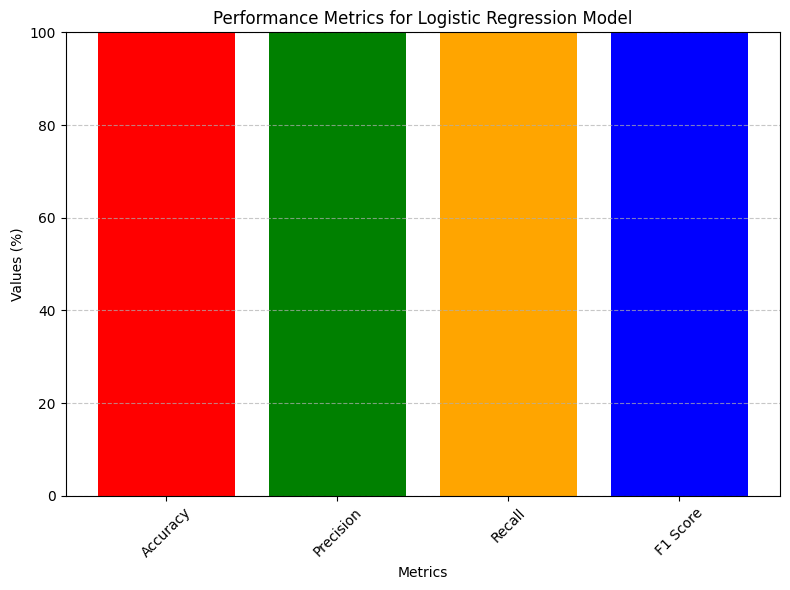

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics and corresponding values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [Accuracy * 100, Precision * 100, Recall * 100, F1 * 100]  # Multiply by 100 for percentage values

# Define colors for each metric
colors = ['red', 'green', 'orange', 'blue']

# Plotting the bar chart

plt.figure(figsize=(8, 6))  # Set figure size
plt.bar(metrics, values, color=colors)  # Create bar plot
plt.xlabel('Metrics')  # Set x-axis label
plt.ylabel('Values (%)')  # Set y-axis label
plt.title('Performance Metrics for Logistic Regression Model')  # Set plot title
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Display the plot


---
# **Task 6 - LSEP Considerations (5 marks)**
---

# **Legal Consideration**

**Dataset License:**
This dataset is publically available to use but it is most important to check the dataset's license information and the terms and conditions of this dataset, and also check any restrictions on data usage, redistribution, modification, and commercial use of the dataset.

**Data Security:**
By using this IDS dataset(2018), take measures to protect the security of the dataset and any associated systems or infrastructure and also implement appropriate security controls to prevent unauthorized access, disclosure, or modification of the data.


---
# **Societal Consideration**

**Privacy Protection:**
This dataset may contain sensitive information about cybersecurity incidents and network vulnerabilities so it is crucial to handle responsibly to protect individuals' privacy and prevent unauthorized access to sensitive information of this data.

**Education and Training:**
This IDS dataset is valuable for educational purposes, providing students, researchers, and cybersecurity professionals. So it can support training programs, courses, and workshops aimed at building cybersecurity skills and knowledge.

---

# **Ethical Consideration**

**Transparency**:
By using this dataset, we want to be transparent about the source, composition, and limitations of the dataset. That can document the data collection process, preprocessing steps, and assumptions made during analysis.

---

# **Professional Consideration**
**Collaboration and Teamwork:**
 The collaboration and teamwork for working with this dataset is good perspectives and expertise to address complex cybersecurity challenges effectively.

**Professional Development:**
Working with this dataset, we have chance to invest in professional development opportunities, such as training programs, certifications, and conferences, to enhance expertise and stay updated on best practices and engage with professional networks and communities to share knowledge and experiences.



---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [6]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [5]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html /content/Group_41_CRWK_CN7030 (1).ipynb

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `jupyter nbconvert --to html /content/Group_41_CRWK_CN7030(1).ipynb'
